In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
import numpy as np
y = y.astype(np.uint8)

Before deskewing

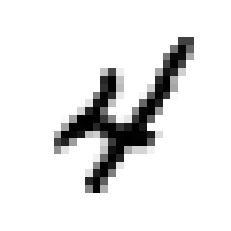

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[9]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

Apply deskewing

In [5]:
#https://fsix.github.io/mnist/Deskewing.html
from scipy.ndimage import interpolation
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [6]:
#https://fsix.github.io/mnist/Deskewing.html
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

X = deskewAll(X)

After Deskewing

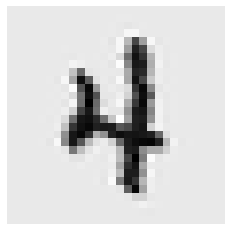

In [7]:
some_digit = X[9]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

MNIST is already divided between training and test sets

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler() #center the distribution around zero (mean), with a standard deviation of 1.
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train) 

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_test_pred = sgd_clf.predict(X_test)

print("Accuracy score: ", (accuracy_score(y_test, y_test_pred)))
#print("Precision score: ", (precision_score(y_test, y_test_pred)))
#print("Recall score: ", (recall_score(y_test, y_test_pred)))

Accuracy score:  0.9234


sgdclassifier: 0.874
Unskewed sgdclassifier: 0.9234

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=3)
knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [13]:
y_test_pred = knc.predict(X_test)

print("Accuracy score: ", (accuracy_score(y_test, y_test_pred)))

Accuracy score:  0.9839


In [14]:
import pickle
file_pickle = open('test.pkl', 'wb')
pickle.dump(knc, file_pickle)
file_pickle.close()